In [26]:
from carbon import CarbonSimulatorUI
from carbon import __version__ as cversion
import numpy as np
from matplotlib import pyplot as plt
from collections import namedtuple
print (f"Carbon Version v{cversion}")

Carbon Version v1.0 BETA1


# Carbon Simulation - Demo 3-2

In this demo we look at an **order book**

Set up the similation, with the pair ETHUSDC as default

In [27]:
TKNB = "ETH"
TKNQ = "USDC"

A number of other preparations here

In [28]:
orders_nt = namedtuple("orders_nt", 'tkn, amt, p_start, p_end')

In [29]:
max_liquidity = 100
trade_sizes = np.linspace(0,max_liquidity, 21)
marg_trade_sizes = np.diff(trade_sizes)
trade_sizes2 = [0.5*(s1+s2) for s1,s2 in zip(trade_sizes, trade_sizes[1:])]
trade_sizes[:3]

array([ 0.,  5., 10.])

In [30]:
trade_sizes[0] = 0.0000001

In [31]:
def effective_price_f(tkn, size):
    """
    returns the price at which `tkn` can be sold in `size` (None if out of liquidity)
    """
    try:
        print(f"[effective_price_f] trading size={size}")
        result = Sim.amm_sells(tkn, size, execute=False)
        #print(f"[effective_price_f] result size={result['trades']}\n\n")
        price = result["trades"].iloc[0]["price"]
        return price
    except:
        return None

In [32]:
def run_calculation():
    """helper function: runs the calculation using global variables"""
    effective_prices = [
        effective_price_f("ETH", size) for size in trade_sizes
    ]
    token_amounts = [
        size * price for size, price in zip(trade_sizes, effective_prices)
    ]
    marg_token_amounts = np.diff(token_amounts)
    marg_prices = [
        amt / size for amt, size in zip(marg_token_amounts, marg_trade_sizes)
    ]
    return effective_prices, token_amounts, marg_token_amounts, marg_prices

In [33]:
def plot_token_amount_chart():
    """helper function: plots the chart using global variables"""
    plt.plot(trade_sizes, token_amounts, label="Token amount")
    plt.plot(trade_sizes2, marg_token_amounts, label="Marginal token amount")
    plt.title("Token amount against trade size")
    plt.xlabel(f"Trade Size ({TKNB})")
    plt.ylabel(f"Token Amount ({TKNQ})")
    plt.grid()
    plt.legend()
    return "plotted marginal and total tokens received against trade size"

In [34]:
def plot_price_chart():
    """helper function: plots the chart using global variables"""
    plt.plot(trade_sizes, effective_prices, label="Effective price")
    plt.plot(trade_sizes2, marg_prices, label="Marginal price")
    plt.title("Price against trade size")
    plt.xlabel(f"Trade Size ({TKNB})")
    plt.ylabel(f"Effective Price ({TKNB} per {TKNQ})")
    plt.grid()
    plt.legend()
    return "plotted marginal and effective price against trade size"

## Order book calculations

In [35]:
Sim = CarbonSimulatorUI(pair=f"{TKNB}{TKNQ}", verbose=False)
Sim

CarbonSimulatorUI(<0 orders, 0 trades>, pair='ETHUSDC')

In [36]:
orders = tuple(
    orders_nt("ETH", 10, 2000, 2000+x*25) for x in range(20)
)
orders[:2]

(orders_nt(tkn='ETH', amt=10, p_start=2000, p_end=2000),
 orders_nt(tkn='ETH', amt=10, p_start=2000, p_end=2025))

In [37]:
for o in orders:
    Sim.add_order(o.tkn, o.amt, o.p_start, o.p_end)
Sim.state()["orders"]

,id,pair,tkn,y_int,y,y_unit,p_start,p_end,p_marg,p_unit,lid
0,0,ETHUSDC,ETH,10.0,10.0,ETH,2000.0,2000.0,2000.0,USDC per ETH,0
1,1,ETHUSDC,ETH,10.0,10.0,ETH,2000.0,2025.0,2000.0,USDC per ETH,1
2,2,ETHUSDC,ETH,10.0,10.0,ETH,2000.0,2050.0,2000.0,USDC per ETH,2
3,3,ETHUSDC,ETH,10.0,10.0,ETH,2000.0,2075.0,2000.0,USDC per ETH,3
4,4,ETHUSDC,ETH,10.0,10.0,ETH,2000.0,2100.0,2000.0,USDC per ETH,4
5,5,ETHUSDC,ETH,10.0,10.0,ETH,2000.0,2125.0,2000.0,USDC per ETH,5
6,6,ETHUSDC,ETH,10.0,10.0,ETH,2000.0,2150.0,2000.0,USDC per ETH,6
7,7,ETHUSDC,ETH,10.0,10.0,ETH,2000.0,2175.0,2000.0,USDC per ETH,7
8,8,ETHUSDC,ETH,10.0,10.0,ETH,2000.0,2200.0,2000.0,USDC per ETH,8
9,9,ETHUSDC,ETH,10.0,10.0,ETH,2000.0,2225.0,2000.0,USDC per ETH,9


In [38]:
Sim.amm_sells("ETH", 80, execute=False)["trades"]

,uid,id,subid,note,aggr,exec,limitfail,amt1,tkn1,amt2,tkn2,pair,routeix,nroutes,price,p_unit
0,0.0,0,0,route #0,False,False,None,10.000000,ETH,20000.000000,USDC,ETHUSDC,0,1,2022.629952,USDC per ETH
0,0.1,0,1,route #1,False,False,None,10.000000,ETH,20124.611797,USDC,ETHUSDC,1,1,2022.629952,USDC per ETH
0,0.2,0,2,route #2,False,False,None,10.000000,ETH,20248.456731,USDC,ETHUSDC,2,1,2022.629952,USDC per ETH
0,0.3,0,3,route #3,False,False,None,7.769019,ETH,15761.370058,USDC,ETHUSDC,3,1,2022.629952,USDC per ETH
0,0.4,0,4,route #4,False,False,None,5.879525,ETH,11928.066120,USDC,ETHUSDC,4,1,2022.629952,USDC per ETH
0,0.5,0,5,route #5,False,False,None,4.745746,ETH,9627.916763,USDC,ETHUSDC,5,1,2022.629952,USDC per ETH
0,0.6,0,6,route #6,False,False,None,3.989827,ETH,8094.347146,USDC,ETHUSDC,6,1,2022.629952,USDC per ETH
0,0.7,0,7,route #7,False,False,None,3.449827,ETH,6998.825131,USDC,ETHUSDC,7,1,2022.629952,USDC per ETH
0,0.8,0,8,route #8,False,False,None,3.044779,ETH,6177.084601,USDC,ETHUSDC,8,1,2022.629952,USDC per ETH
0,0.9,0,9,route #9,False,False,None,2.729699,ETH,5537.866557,USDC,ETHUSDC,9,1,2022.629952,USDC per ETH


In [39]:
#Sim.amm_sells("ETH", 25, execute=True)["trades"]

In [40]:
effective_prices, token_amounts, marg_token_amounts, marg_prices = run_calculation()

[effective_price_f] trading size=1e-07
[effective_price_f] trading size=5.0
[effective_price_f] trading size=10.0
[effective_price_f] trading size=15.0
[effective_price_f] trading size=20.0
[effective_price_f] trading size=25.0
[effective_price_f] trading size=30.0
[effective_price_f] trading size=35.0
[effective_price_f] trading size=40.0
[effective_price_f] trading size=45.0
[effective_price_f] trading size=50.0
[effective_price_f] trading size=55.0
[effective_price_f] trading size=60.0
[effective_price_f] trading size=65.0
[effective_price_f] trading size=70.0
[effective_price_f] trading size=75.0
[effective_price_f] trading size=80.0
[effective_price_f] trading size=85.0
[effective_price_f] trading size=90.0
[effective_price_f] trading size=95.0
[effective_price_f] trading size=100.0


In [41]:
Sim.state()["trades"].query("aggr==True")

,uid,id,subid,note,aggr,exec,limitfail,amt1,tkn1,amt2,tkn2,pair,routeix,nroutes,price,p_unit
0,0,0,A,AMM sells 80ETH buys 161810USDC,True,False,None,80.0,ETH,161810.396146,USDC,ETHUSDC,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",20,2022.629952,USDC per ETH
0,1,1,A,AMM sells 0ETH buys 0USDC,True,False,None,0.0,ETH,0.000200,USDC,ETHUSDC,[0],1,2000.0,USDC per ETH
0,2,2,A,AMM sells 5ETH buys 10000USDC,True,False,None,5.0,ETH,10000.000000,USDC,ETHUSDC,[0],1,2000.0,USDC per ETH
0,3,3,A,AMM sells 10ETH buys 20000USDC,True,False,None,10.0,ETH,20000.000000,USDC,ETHUSDC,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",20,2000.0,USDC per ETH
0,4,4,A,AMM sells 15ETH buys 30008USDC,True,False,None,15.0,ETH,30008.398235,USDC,ETHUSDC,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",20,2000.559882,USDC per ETH
0,5,5,A,AMM sells 20ETH buys 40034USDC,True,False,None,20.0,ETH,40033.621177,USDC,ETHUSDC,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",20,2001.681059,USDC per ETH
0,6,6,A,AMM sells 25ETH buys 50076USDC,True,False,None,25.0,ETH,50075.711287,USDC,ETHUSDC,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",20,2003.028451,USDC per ETH
0,7,7,A,AMM sells 30ETH buys 60135USDC,True,False,None,30.0,ETH,60134.711167,USDC,ETHUSDC,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",20,2004.490372,USDC per ETH
0,8,8,A,AMM sells 35ETH buys 70211USDC,True,False,None,35.0,ETH,70210.663566,USDC,ETHUSDC,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",20,2006.018959,USDC per ETH
0,9,9,A,AMM sells 40ETH buys 80304USDC,True,False,None,40.0,ETH,80303.611375,USDC,ETHUSDC,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",20,2007.590284,USDC per ETH


'plotted marginal and total tokens received against trade size'

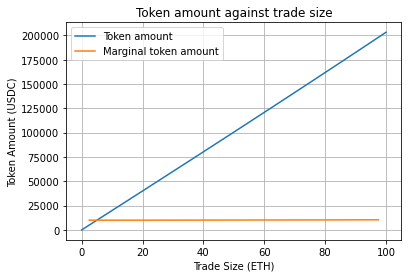

In [42]:
plot_token_amount_chart()

'plotted marginal and effective price against trade size'

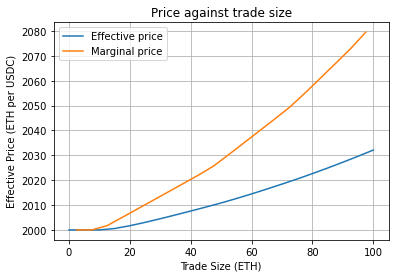

In [43]:
plot_price_chart()

In [51]:
def plot_orderbook_chart():
    """helper function: plots the chart using global variables"""
    plt.plot(marg_prices, marg_token_amounts, label="Orders")
    plt.title("Order Book")
    plt.xlabel(f"Effective Price ({TKNB} per {TKNQ})")
    plt.ylabel(f"Liquidity Size ({TKNB})")
    plt.grid()
    plt.legend()
    plt.xlim(1900,2200)
    plt.ylim(0,11000)
    return "plotted order book"

'plotted order book'

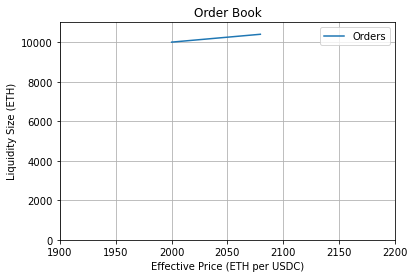

In [52]:
plot_orderbook_chart()

In [46]:
marg_token_amounts

array([ 9999.9998  , 10000.      , 10008.39823 , 10025.22295 ,
       10042.090095, 10058.999885, 10075.952405, 10092.947795,
       10109.98625 , 10128.29449 , 10151.34363 , 10174.93145 ,
       10198.60151 , 10222.35425 , 10246.51001 , 10274.76321 ,
       10304.34213 , 10334.04894 , 10363.929925, 10397.323745])